# Assignment 1 of Homework 11 for PUI 2016
Thursday Session

** Name:** Cheng Hou

** NetID:** ch3019

---

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pylab as pl
import os
import subprocess as sp
import geopandas as gpd
from fiona.crs import from_epsg
import json
import shapely
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    
%pylab inline

if os.getenv("PUIDATA") is None:
    print ("error: $PUIDATA env variable does not exist!")
else:
    puidata = os.getenv("PUIDATA")
    if not os.path.exists(puidata):
        os.system("mkdir " + puidata)
    print ("$PUIDATA: {}".format(puidata))

Populating the interactive namespace from numpy and matplotlib
$PUIDATA: /home/cusp/ch3019/PUIdata


---
## 1. Download Data
Download Census Blocks Data from the [NYC planning website](http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page).

The dataset is [Census Blocks 2010 (Clipped to Shoreline)](http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip) in the Census Blocks & Tracts Tab.

In [2]:
def getCensusBlocks(zipfilename='nycb2010_16d.zip',
                    url='http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip',
                    overview=False):
    
    if not os.path.isfile(puidata + '/' + zipfilename):
        if not os.path.isfile(zipfilename):            
            if os.system("wget " + url) != 0:
                print ("error: Cannot download file : {}".format(zipfilename))
                return 1
        os.system("mv " + zipfilename + " " + puidata)
    print ("The zip file moves to {}".format(puidata))
    os.system("unzip -u " + puidata + '/' + zipfilename + " -d " + puidata)
    fdir = puidata + '/' + zipfilename[:-4] + '/'
    print ("Unzip the file to {}".format(fdir))
    
    # Overview
    if overview:
        cmd = 'cd {}; ls'.format(fdir)
        p = sp.Popen(cmd, shell=True, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT, close_fds=True)
        print (p.stdout.read())
    cmd = "find {} -name *.shp".format(fdir)
    p = sp.Popen(cmd, shell=True, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT, close_fds=True)
    filename = p.stdout.readlines()[0][:-1]
    
    # Add to getCensusBlocks Attributes
    getCensusBlocks.zipfilename = zipfilename
    getCensusBlocks.url = url
    getCensusBlocks.filename = filename    
    print ("Complete.")
    return 0

In [3]:
getCensusBlocks()
shape_path = getCensusBlocks.filename

The zip file moves to /home/cusp/ch3019/PUIdata
Unzip the file to /home/cusp/ch3019/PUIdata/nycb2010_16d/
Complete.


## 2. Read Data, Convert coordinate system, Select only the Brooklyn shape polygons

In [4]:
ct_shape = gpd.GeoDataFrame.from_file(shape_path)
ct_shape.crs = from_epsg(2263)
ct_shape = ct_shape.to_crs(epsg=4326)
ct_shape.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,POLYGON ((-74.07920577013245 40.64343078374566...
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438018 40.61085506705415...
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,POLYGON ((-74.07524403910642 40.62600632452711...
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,POLYGON ((-74.08708799689826 40.61116883123923...
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511992 40.60100160655585...


In [5]:
print (ct_shape.BoroName.unique())

[u'Staten Island' u'Manhattan' u'Brooklyn' u'Bronx' u'Queens']


In [6]:
ct_bk_shape = ct_shape[ct_shape.BoroName == 'Brooklyn'].reset_index(drop=True)
ct_bk_shape.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
1,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384567195...
2,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,POLYGON ((-73.99270830309769 40.69809925981344...
3,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,POLYGON ((-73.98514306089652 40.69488514296981...
4,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793354038...


## 3. Find the coordinates of CUSP
Use ** *Google Maps Geocoding API* ** to get the latitude and longitude of CUSP.

I stored my google api in text file "**GOOGLEAPI.txt**".

The address of CUSP is **1 MetroTech Center, 19th Floor, Brooklyn, NY 11201**

In [7]:
fin = open("GOOGLEAPI.txt", "r")
api = fin.read()
address = "1+MetroTech+Center,+19th+Floor,+Brooklyn,+NY+11201"
url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(address,api)
response = urllib.urlopen(url)
lalonjson = json.loads(response.read().decode("utf-8"))

In [8]:
la, lon = lalonjson['results'][0]['geometry']['location'].values()
CUSP = shapely.geometry.Point(lon, la)
CUSP.crs = from_epsg(4326)

## 4. Loop over the Brookly polygons and assess find in which geometry the polygon is contained

In [9]:
ct_CUSP = ct_bk_shape[ct_bk_shape.geometry.contains(CUSP)].reset_index(drop=True)
ct_CUSP

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,30011001009,3,Brooklyn,1009,001100,69934.269433,1061.280668,"POLYGON ((-73.98619262163143 40.693753518938, ..."


In [10]:
print("CUSP is contained in {}".format((ct_CUSP.ix[0].geometry)))

CUSP is contained in POLYGON ((-73.98619262163143 40.693753518938, -73.98621117787486 40.69338386010246, -73.98622595691907 40.69308831340506, -73.98725396415627 40.6931249027317, -73.98722751058246 40.69379951950234, -73.98619262163143 40.693753518938))


## 5. Plot one every 10 polygons of brooklyn and overplot the location of cusp as a point. Overplot also the census track that contains cusp in red.

In [11]:
indx = np.arange(0, len(ct_bk_shape), 10)
ct_plot = ct_bk_shape.iloc[indx,:]

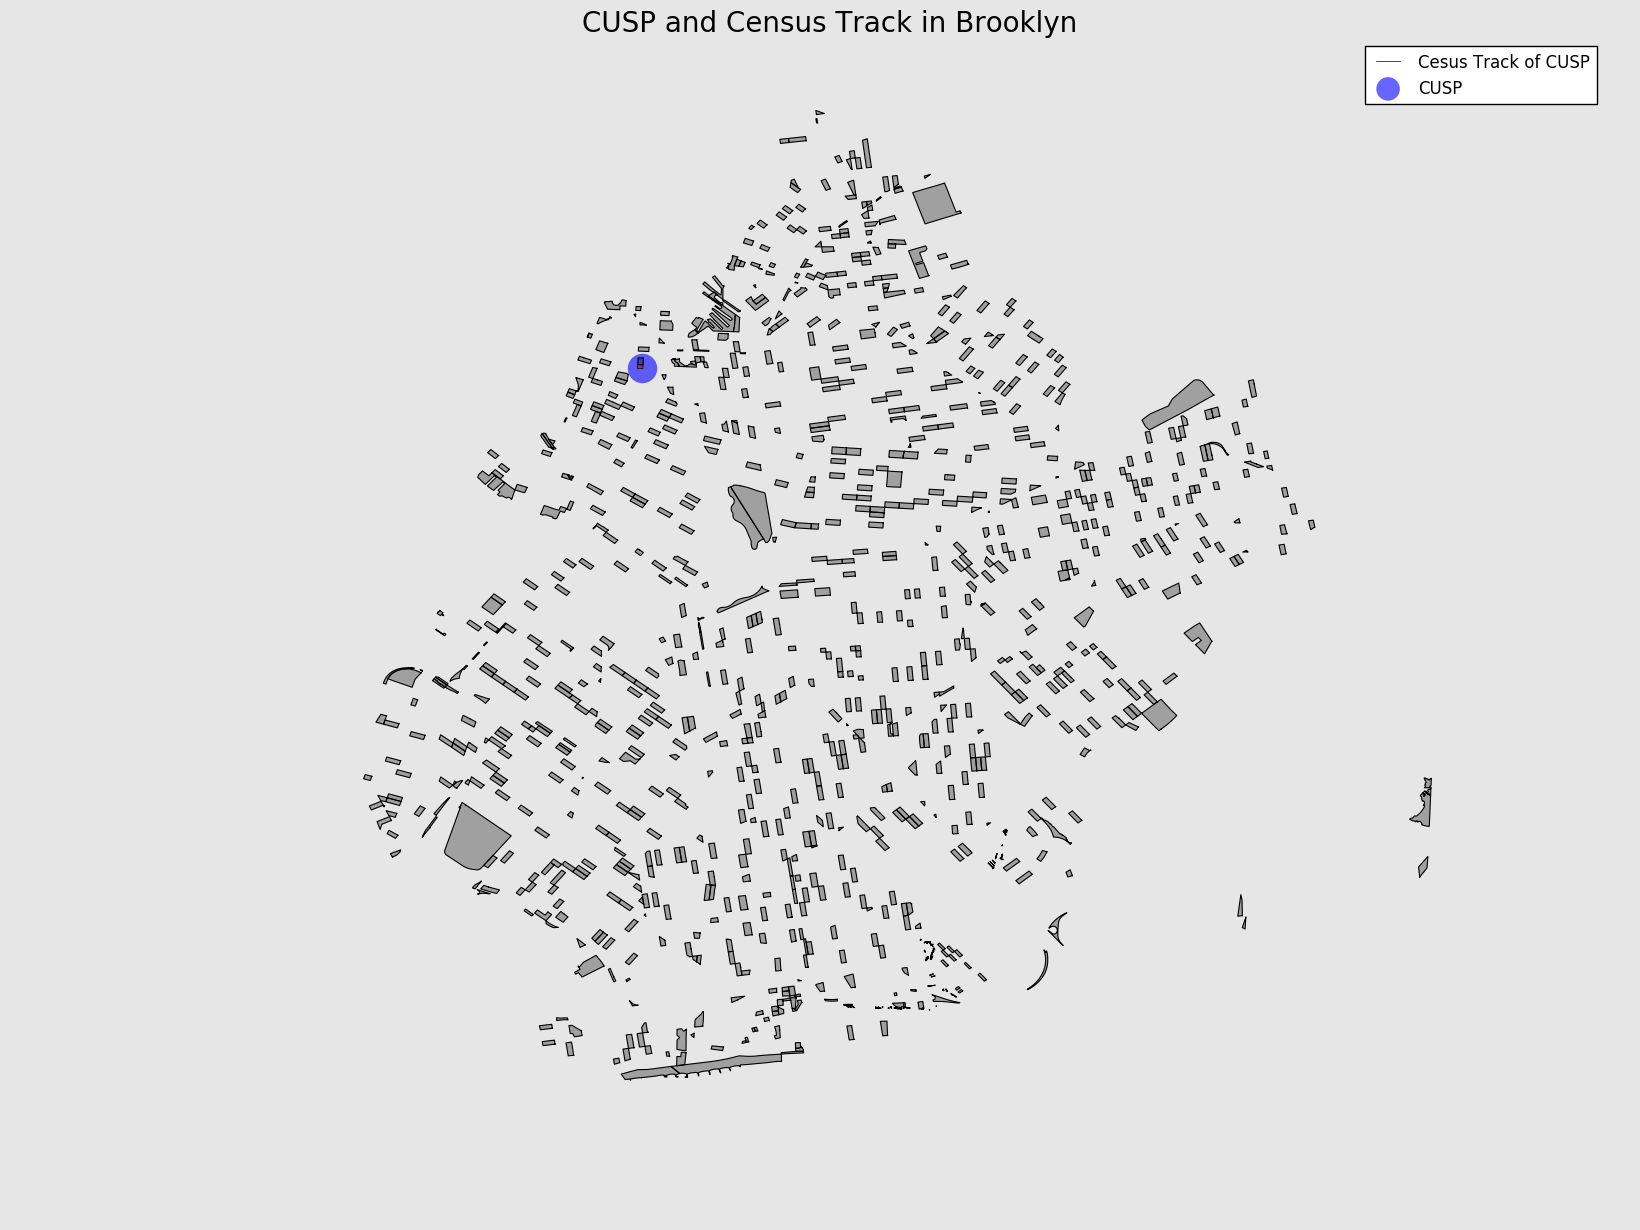

In [31]:
fig, ax = pl.subplots(figsize=(20,15))
# polygons of brooklyn
ct_plot.plot(ax=ax, color='black', alpha=0.3, linewidth=0.8)
# CUSP
ax.scatter(lon, la, s=450, lw=0, c='blue', alpha=0.6, label='CUSP')
# the census track that contains cusp
ct_CUSP.plot(ax=ax, color='red', legend=True, linewidth=0.5, label='Cesus Track of CUSP')
ax.legend(markerscale=0.8, scatterpoints=1)
ax.set_title('CUSP and Census Track in Brooklyn', fontsize=20)
fig.set_facecolor('0.9')
ax.set_axis_off()